In [97]:

# 导入模块
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matminer.datasets import load_dataset
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.feature_selection import VarianceThreshold
from jarvis.core.composition import Composition
from jarvis.core.specie import Specie
from jarvis.ai.descriptors.elemental import get_element_fraction_desc
from jarvis.ai.pkgs.utils import regr_scores, mean_absolute_deviation
from jarvis.ai.descriptors.cfid import get_chem_only_descriptors
from jarvis.ai.descriptors.cfid import CFID
#import shap
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [98]:

# 读取数据 我把论文公开的数据由excel另存成了csv，其余保持不变。论文原文是用matlab做的，但pandas读取excel还是不太方便
# 假设你的DataFrame是df
df = pd.read_csv('structure_features_with_jarvis.csv')
df

,Filename,Space group number,Band Gap (eV),Debye T (K),bp_mult_atom_rad,hfus_add_bp,elec_aff_mult_voro_coord,mol_vol_subs_atom_mass,is_halogen,atom_mass_subs_first_ion_en,...,nn_90,nn_91,nn_92,nn_93,nn_94,nn_95,nn_96,nn_97,nn_98,nn_99
0,Al2BaS4,205,3.65,363,2938.4400,1884.355170,4.831667,-44.227846,0.000000,58.272032,...,0.015093,0.015545,0.025865,0.011915,0.014584,0.014283,0.015391,0.009596,0.005374,0
1,Al2Br7K,14,4.23,83,2047.4000,1385.394433,7.641333,-23.421280,0.333333,41.281202,...,0.026146,0.019807,0.031502,0.023722,0.034067,0.029574,0.026742,0.034207,0.033523,0
2,Al4BaS7,31,3.16,366,2938.4400,1884.355170,4.831667,-44.227846,0.000000,58.272032,...,0.062351,0.026785,0.046605,0.057030,0.041881,0.046487,0.053574,0.038057,0.075877,0
3,Al3Ba17O7,138,0.00,281,2717.1900,1675.126833,3.575000,-38.262646,0.000000,51.830819,...,0.008800,0.006739,0.008305,0.008130,0.007024,0.012383,0.010558,0.009685,0.007765,0
4,Al3Br12La,152,2.61,271,3723.5500,2289.073983,7.948000,-64.540336,0.333333,74.138180,...,0.016806,0.015478,0.017042,0.029659,0.019966,0.024887,0.013060,0.013649,0.016721,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003,NdO12P4Rb,14,5.45,368,2275.6300,1243.620225,4.630000,-41.488241,0.000000,60.719023,...,0.016487,0.013738,0.011409,0.012764,0.011229,0.013866,0.012834,0.018173,0.014932,0
2004,O12P4RbTm,14,5.47,422,1688.1800,956.144475,4.505000,-48.033793,0.000000,66.727249,...,0.012239,0.012560,0.011625,0.014179,0.014797,0.016907,0.013408,0.011505,0.012790,0
2005,O12P4RbY,14,5.48,350,2339.6675,1302.630850,3.944000,-27.831703,0.000000,46.711911,...,0.012439,0.010775,0.013865,0.010324,0.015443,0.015217,0.016163,0.014693,0.010174,0
2006,O12P4RbTb,14,5.49,344,2248.1800,1276.127750,4.630000,-45.481578,0.000000,64.305161,...,0.012235,0.011373,0.013279,0.010897,0.014507,0.015858,0.015355,0.015397,0.010519,0


In [99]:
# 复制 DataFrame，并只保留 'Filename' 和 'Debye T (K)' 列
df_target = df[['Filename', 'Debye T (K)']].copy()

# 将 'Filename' 列重命名为 'formula'，将 'Debye T (K)' 列重命名为 'target'
df_target.rename(columns={'Filename': 'formula', 'Debye T (K)': 'target'}, inplace=True)

# 打印复制后的 DataFrame
print(df_target.head())

     formula  target
0    Al2BaS4     363
1    Al2Br7K      83
2    Al4BaS7     366
3  Al3Ba17O7     281
4  Al3Br12La     271


In [30]:
from CBFV import composition
import pandas as pd
import numpy as np
# 从您的数据框中准备特征向量和目标变量
X_cfid, y, formulae, skipped = composition.generate_features(df_target, elem_prop='oliynyk')

# 将特征向量添加到原始 DataFrame 中
df_with_X = pd.concat([df_target, pd.DataFrame(X_cfid)], axis=1)

# 打印合并后的 DataFrame
print(df_with_X)

Processing Input Data: 100%|████████████████████████████████████████████████████| 2008/2008 [00:00<00:00, 29963.47it/s]


	Featurizing Compositions...


Assigning Features...: 100%|████████████████████████████████████████████████████| 2008/2008 [00:00<00:00, 14339.62it/s]


	Creating Pandas Objects...
        formula  target  avg_Atomic_Number  avg_Atomic_Weight  avg_Period  \
0       Al2BaS4     363          20.857143          45.650583    3.428571   
1       Al2Br7K      83          29.000000          65.238938    3.800000   
2       Al4BaS7     366          18.333333          39.142930    3.250000   
3     Al3Ba17O7     281          38.777778          93.611090    4.629630   
4     Al3Br12La     271          32.250000          73.668632    3.937500   
...         ...     ...                ...                ...         ...   
2003  NdO12P4Rb     368          14.055556          30.310869    2.611111   
2004  O12P4RbTm     422          14.555556          31.682770    2.611111   
2005   O12P4RbY     350          12.888889          27.236750    2.555556   
2006  O12P4RbTb     344          14.333333          31.126722    2.611111   
2007  NaO12P3V3     461          11.631579          24.248861    2.526316   

      avg_group  avg_families  avg_Metal  avg_N

In [32]:
df_new = pd.concat([df, df_with_X], axis=1)
df_new

,Filename,Space group number,Band Gap (eV),Debye T (K),bp_mult_atom_rad,hfus_add_bp,elec_aff_mult_voro_coord,mol_vol_subs_atom_mass,is_halogen,atom_mass_subs_first_ion_en,...,mode_polarizability(A^3),mode_Melting_point_(K),mode_Boiling_Point_(K),mode_Density_(g/mL),mode_specific_heat_(J/g_K)_,mode_heat_of_fusion_(kJ/mol)_,mode_heat_of_vaporization_(kJ/mol)_,mode_thermal_conductivity_(W/(m_K))_,mode_heat_atomization(kJ/mol),mode_Cohesive_energy
0,Al2BaS4,205,3.65,363,2938.4400,1884.355170,4.831667,-44.227846,0.000000,58.272032,...,2.900,385.95,717.85,2.07000,0.710,1.71750,9.8000,0.26900,279.0,2.85
1,Al2Br7K,14,4.23,83,2047.4000,1385.394433,7.641333,-23.421280,0.333333,41.281202,...,3.100,265.95,331.95,3.12000,0.473,5.28600,15.4380,0.12200,112.0,1.22
2,Al4BaS7,31,3.16,366,2938.4400,1884.355170,4.831667,-44.227846,0.000000,58.272032,...,2.900,385.95,717.85,2.07000,0.710,1.71750,9.8000,0.26900,279.0,2.85
3,Al3Ba17O7,138,0.00,281,2717.1900,1675.126833,3.575000,-38.262646,0.000000,51.830819,...,39.700,998.15,1913.15,3.50000,0.204,7.75000,142.0000,18.40000,180.0,1.90
4,Al3Br12La,152,2.61,271,3723.5500,2289.073983,7.948000,-64.540336,0.333333,74.138180,...,3.100,265.95,331.95,3.12000,0.473,5.28600,15.4380,0.12200,112.0,1.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003,NdO12P4Rb,14,5.45,368,2275.6300,1243.620225,4.630000,-41.488241,0.000000,60.719023,...,0.793,54.75,90.15,0.00143,0.920,0.22259,3.4099,0.02674,249.0,2.62
2004,O12P4RbTm,14,5.47,422,1688.1800,956.144475,4.505000,-48.033793,0.000000,66.727249,...,0.793,54.75,90.15,0.00143,0.920,0.22259,3.4099,0.02674,249.0,2.62
2005,O12P4RbY,14,5.48,350,2339.6675,1302.630850,3.944000,-27.831703,0.000000,46.711911,...,0.793,54.75,90.15,0.00143,0.920,0.22259,3.4099,0.02674,249.0,2.62
2006,O12P4RbTb,14,5.49,344,2248.1800,1276.127750,4.630000,-45.481578,0.000000,64.305161,...,0.793,54.75,90.15,0.00143,0.920,0.22259,3.4099,0.02674,249.0,2.62


In [100]:
# 设置 y 和 X
y = df_new['Debye T (K)']  # 将 'Debye T (K)' 列设为目标变量
X = df_new.drop(columns=['Filename', 'Debye T (K)', 'formula', 'target'])  # 删除 'Filename' 和 'Debye T (K)' 列，其余列作为特征变量
X

,Space group number,Band Gap (eV),bp_mult_atom_rad,hfus_add_bp,elec_aff_mult_voro_coord,mol_vol_subs_atom_mass,is_halogen,atom_mass_subs_first_ion_en,row,mol_vol_mult_atom_mass,...,mode_polarizability(A^3),mode_Melting_point_(K),mode_Boiling_Point_(K),mode_Density_(g/mL),mode_specific_heat_(J/g_K)_,mode_heat_of_fusion_(kJ/mol)_,mode_heat_of_vaporization_(kJ/mol)_,mode_thermal_conductivity_(W/(m_K))_,mode_heat_atomization(kJ/mol),mode_Cohesive_energy
0,205,3.65,2938.4400,1884.355170,4.831667,-44.227846,0.000000,58.272032,4.000000,2002.727719,...,2.900,385.95,717.85,2.07000,0.710,1.71750,9.8000,0.26900,279.0,2.85
1,14,4.23,2047.4000,1385.394433,7.641333,-23.421280,0.333333,41.281202,3.666667,1215.497469,...,3.100,265.95,331.95,3.12000,0.473,5.28600,15.4380,0.12200,112.0,1.22
2,31,3.16,2938.4400,1884.355170,4.831667,-44.227846,0.000000,58.272032,4.000000,2002.727719,...,2.900,385.95,717.85,2.07000,0.710,1.71750,9.8000,0.26900,279.0,2.85
3,138,0.00,2717.1900,1675.126833,3.575000,-38.262646,0.000000,51.830819,3.666667,1929.321097,...,39.700,998.15,1913.15,3.50000,0.204,7.75000,142.0000,18.40000,180.0,1.90
4,152,2.61,3723.5500,2289.073983,7.948000,-64.540336,0.333333,74.138180,5.000000,1653.469993,...,3.100,265.95,331.95,3.12000,0.473,5.28600,15.4380,0.12200,112.0,1.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003,14,5.45,2275.6300,1243.620225,4.630000,-41.488241,0.000000,60.719023,4.500000,2135.137580,...,0.793,54.75,90.15,0.00143,0.920,0.22259,3.4099,0.02674,249.0,2.62
2004,14,5.47,1688.1800,956.144475,4.505000,-48.033793,0.000000,66.727249,4.500000,2199.312738,...,0.793,54.75,90.15,0.00143,0.920,0.22259,3.4099,0.02674,249.0,2.62
2005,14,5.48,2339.6675,1302.630850,3.944000,-27.831703,0.000000,46.711911,3.750000,1834.513960,...,0.793,54.75,90.15,0.00143,0.920,0.22259,3.4099,0.02674,249.0,2.62
2006,14,5.49,2248.1800,1276.127750,4.630000,-45.481578,0.000000,64.305161,4.500000,2159.466699,...,0.793,54.75,90.15,0.00143,0.920,0.22259,3.4099,0.02674,249.0,2.62


In [68]:
# 获取 X 中的所有字符串列
string_columns = X.select_dtypes(include='object').columns

# 如果存在字符串列，则打印出列名
if len(string_columns) > 0:
    print("X 中包含以下字符串列:")
    print(string_columns)
else:
    print("X 中不包含字符串列.")

X 中不包含字符串列.


In [102]:
# 设置 y 和 X
y = df['Debye T (K)']  # 将 'Debye T (K)' 列设为目标变量
X = df.drop(columns=['Filename', 'Debye T (K)'])  # 删除 'Filename' 和 'Debye T (K)' 列，其余列作为特征变量
X

,Space group number,Band Gap (eV),bp_mult_atom_rad,hfus_add_bp,elec_aff_mult_voro_coord,mol_vol_subs_atom_mass,is_halogen,atom_mass_subs_first_ion_en,row,mol_vol_mult_atom_mass,...,nn_90,nn_91,nn_92,nn_93,nn_94,nn_95,nn_96,nn_97,nn_98,nn_99
0,205,3.65,2938.4400,1884.355170,4.831667,-44.227846,0.000000,58.272032,4.000000,2002.727719,...,0.015093,0.015545,0.025865,0.011915,0.014584,0.014283,0.015391,0.009596,0.005374,0
1,14,4.23,2047.4000,1385.394433,7.641333,-23.421280,0.333333,41.281202,3.666667,1215.497469,...,0.026146,0.019807,0.031502,0.023722,0.034067,0.029574,0.026742,0.034207,0.033523,0
2,31,3.16,2938.4400,1884.355170,4.831667,-44.227846,0.000000,58.272032,4.000000,2002.727719,...,0.062351,0.026785,0.046605,0.057030,0.041881,0.046487,0.053574,0.038057,0.075877,0
3,138,0.00,2717.1900,1675.126833,3.575000,-38.262646,0.000000,51.830819,3.666667,1929.321097,...,0.008800,0.006739,0.008305,0.008130,0.007024,0.012383,0.010558,0.009685,0.007765,0
4,152,2.61,3723.5500,2289.073983,7.948000,-64.540336,0.333333,74.138180,5.000000,1653.469993,...,0.016806,0.015478,0.017042,0.029659,0.019966,0.024887,0.013060,0.013649,0.016721,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003,14,5.45,2275.6300,1243.620225,4.630000,-41.488241,0.000000,60.719023,4.500000,2135.137580,...,0.016487,0.013738,0.011409,0.012764,0.011229,0.013866,0.012834,0.018173,0.014932,0
2004,14,5.47,1688.1800,956.144475,4.505000,-48.033793,0.000000,66.727249,4.500000,2199.312738,...,0.012239,0.012560,0.011625,0.014179,0.014797,0.016907,0.013408,0.011505,0.012790,0
2005,14,5.48,2339.6675,1302.630850,3.944000,-27.831703,0.000000,46.711911,3.750000,1834.513960,...,0.012439,0.010775,0.013865,0.010324,0.015443,0.015217,0.016163,0.014693,0.010174,0
2006,14,5.49,2248.1800,1276.127750,4.630000,-45.481578,0.000000,64.305161,4.500000,2159.466699,...,0.012235,0.011373,0.013279,0.010897,0.014507,0.015858,0.015355,0.015397,0.010519,0


In [103]:
#去除无效特征
sel = VarianceThreshold(threshold=(0.70*(1-0.70)))
X = sel.fit_transform(X)
feature_intex = sel.get_support()
print('number of features after remove redundant ones:',sum(feature_intex))

number of features after remove redundant ones: 911


number of features after remove redundant ones: 399


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1561 but corresponding boolean dimension is 399

In [104]:
# 计算相关矩阵spearmanr
from scipy.stats import spearmanr
correlation_matrix = spearmanr(X, axis=0).correlation
# 设置相关性阈值
correlation_threshold = 0.8
# 找到相关性大于阈值的变量索引
strong_correlation_indices = np.where(np.abs(correlation_matrix) > correlation_threshold)
# 去重，确保每个变量只被保留一次
unique_correlation_indices = set()
for i, j in zip(strong_correlation_indices[0], strong_correlation_indices[1]):
    if i != j:
        unique_correlation_indices.add((i, j))
# 将相关性强的变量重新赋值给X_cfid
selected_features_indices = [index for indices in unique_correlation_indices for index in indices]
selected_features_indices = list(set(selected_features_indices))  # 去重
X = X[:, selected_features_indices]
X.shape

(2008, 399)

In [123]:
# 检查特征数量是否正确
if len(feature_intex) != len(df.columns):
    raise ValueError("Number of features after selection does not match original dataframe.")

ValueError: Number of features after selection does not match original dataframe.

In [105]:
# 拆分数据集,留20%的数据给测试（验证）集
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, shuffle=True)
# 数据标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [106]:
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor

model = RandomForestRegressor()

In [107]:
# 对超参数进行网格搜索，SVM三个主要超参数都有涉及
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [None, 10, 20, 50]
}

In [108]:
# 网格搜索+10折交叉验证，以“neg_mean_squared_error”作为打分条件
grid_search = GridSearchCV(model, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 50],
                         'n_estimators': [50, 100, 200, 500]},
             scoring='neg_mean_squared_error')

In [87]:
# 把表现最好的超参数提出来，打印出来看看是什么组合
best_params = grid_search.best_params_
print('Best Parameters:', best_params)

Best Parameters: {'max_depth': None, 'n_estimators': 100}


In [109]:
#把包含最佳超参数的模型实例化给新模型best_model，方便后面使用
best_model = grid_search.best_estimator_

In [110]:
# 在训练集上再用最好的模型拟合一次
best_model.fit(X_train_scaled,y_train)

RandomForestRegressor(max_depth=20, n_estimators=50)

In [111]:
# 在训练集上进行预测
y_train_pred = best_model.predict(X_train_scaled)

In [112]:
from sklearn.metrics import mean_squared_error
# 计算训练集上的MAE（mean_absolute_error）
train_mae = mean_absolute_error(y_train, y_train_pred)
train_R2 = r2_score(y_train, y_train_pred)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)

print(f'Training Set mean_absolute_error: {train_mae}')
print(f'Training Set R2: {train_R2}')
print(f'Training Set RMSE: {train_rmse}')

Training Set mean_absolute_error: 28.96446191219828
Training Set R2: 0.9359188923535557
Training Set RMSE: 41.93042498856831


D:\Users\Tingxi Chen\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [113]:
# 在训练集上再用最好的模型拟合一次
best_model.fit(X_test_scaled,y_test)

# 在训练集上进行预测
y_pred = best_model.predict(X_test_scaled)

In [114]:
# 评估模型性能
test_mae = mean_absolute_error(y_test, y_pred)
test_R2 = r2_score(y_test, y_pred)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Test Set mean_absolute_error: {test_mae}')
print(f'Test Set R2: {test_R2}')
print(f'Training Set RMSE: {test_rmse}')

Test Set mean_absolute_error: 30.75104927742241
Test Set R2: 0.9317291570484673
Training Set RMSE: 46.332790083452885


D:\Users\Tingxi Chen\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


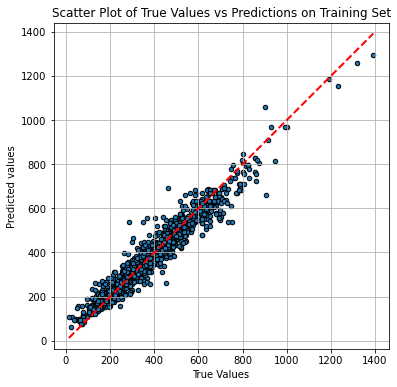

In [115]:
# 可视化函数
def plot_scatter(true_values, predicted_values, title):
    plt.figure(figsize=(6, 6))
    plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], color='red', linestyle='--', linewidth=2)
    plt.scatter(true_values, predicted_values, edgecolor='black', s=20)
    plt.axis('equal')
    plt.xlabel('True Values')
    plt.ylabel('Predicted values')
    plt.title(title)
    plt.grid(True)
    plt.show()

# 可视化训练集上的真实值和预测值
plot_scatter(y_train, y_train_pred, 'Scatter Plot of True Values vs Predictions on Training Set')

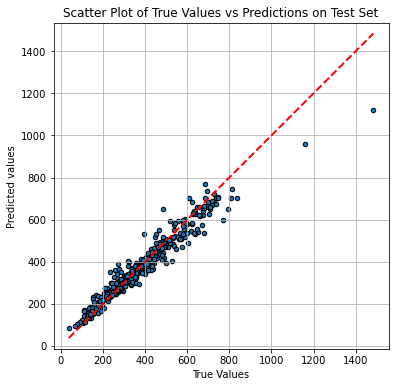

In [116]:
# 可视化测试集上的真实值和预测值
plot_scatter(y_test, y_pred, 'Scatter Plot of True Values vs Predictions on Test Set')

Debye temperature of NaBaB9O15: 688.3 K
Debye temperature of NaBaB9O15 in Ref(ML).: 729 K
Debye temperature of NaBaB9O15 in Ref(Cal).: 635 K


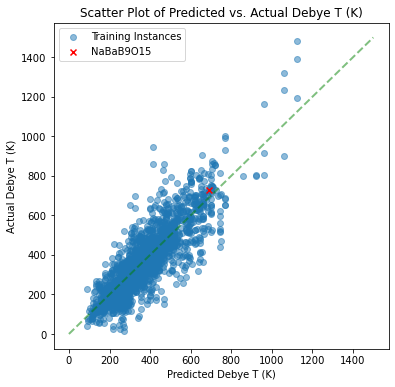

In [117]:
# 找到 Formula是 "NaBaB9O15"的数据，把他索引出来
index_na_ba_b9_o15 = df[df['Filename'] == 'B9BaNaO15'].index[0]
# 在所有数据上预测一遍（这步不是必要的，主要为了复现论文）
X_all_scaled = scaler.transform(X)
# 预测
predicted_values = best_model.predict(X_all_scaled)
# 打印一下数据
print(f'Debye temperature of NaBaB9O15: {predicted_values[index_na_ba_b9_o15]} K')
print('Debye temperature of NaBaB9O15 in Ref(ML).: 729 K')
print('Debye temperature of NaBaB9O15 in Ref(Cal).: 635 K')
# 比文献的预测值还要准确一点点
plt.figure(figsize=(6, 6))
plt.plot([0, 1500], [0, 1500], color='green', alpha=0.5, linestyle='--', linewidth=2)
plt.scatter(predicted_values, y, alpha=0.5, label='Training Instances')
plt.scatter(predicted_values[index_na_ba_b9_o15], y[index_na_ba_b9_o15], color='red', label='NaBaB9O15', marker='x')
plt.xlabel('Predicted Debye T (K)')
plt.ylabel('Actual Debye T (K)')
plt.legend()
plt.title('Scatter Plot of Predicted vs. Actual Debye T (K)')
plt.show()

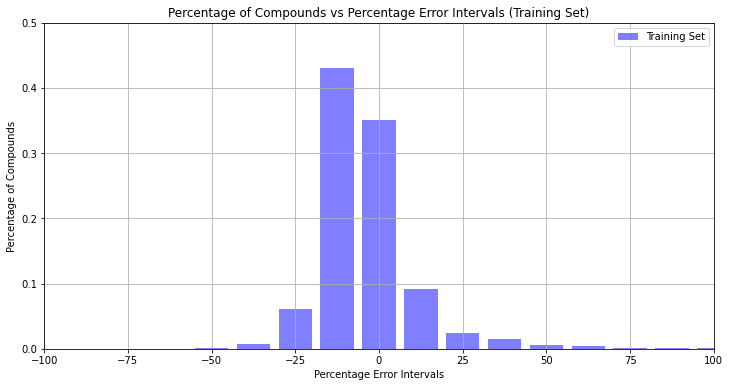

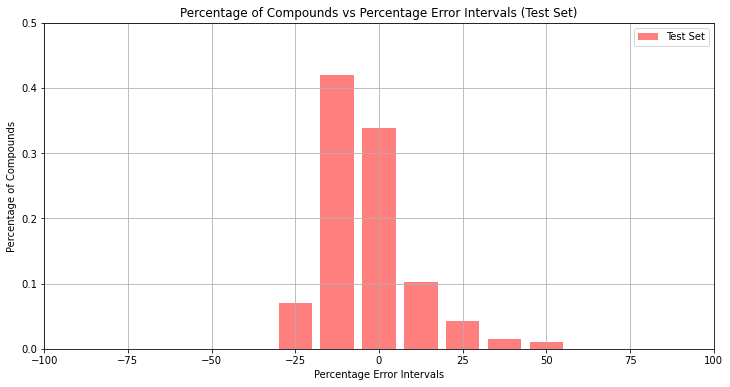

In [118]:
# 设置误差率的区间，细分为12.5
error_intervals = np.arange(-100, 101, 12.5)

# 计算训练集误差率
train_percentage_error = ((y_train_pred - y_train) / y_train) * 100

# 计算测试集误差率
test_percentage_error = ((y_pred - y_test) / y_test) * 100

# 计算训练集和测试集的数据总数
total_train_samples = len(train_percentage_error)
total_test_samples = len(test_percentage_error)

# 计算训练集和测试集在每个误差率区间内的数据占比
train_percentage = []
test_percentage = []

for interval in error_intervals:
    train_samples_in_interval = ((train_percentage_error >= interval) & (train_percentage_error < interval + 12.5)).sum()
    test_samples_in_interval = ((test_percentage_error >= interval) & (test_percentage_error < interval + 12.5)).sum()
    
    train_percentage.append(train_samples_in_interval / total_train_samples)
    test_percentage.append(test_samples_in_interval / total_test_samples)

# 绘制训练集的条形图
plt.figure(figsize=(12, 6))
plt.bar(error_intervals, train_percentage, width=10, color='blue', alpha=0.5, label='Training Set')
plt.title('Percentage of Compounds vs Percentage Error Intervals (Training Set)')
plt.xlabel('Percentage Error Intervals')
plt.ylabel('Percentage of Compounds')
plt.xlim(-100, 100)
plt.ylim(0, 0.5)
plt.legend()
plt.grid(True)
plt.show()

# 绘制测试集的条形图
plt.figure(figsize=(12, 6))
plt.bar(error_intervals, test_percentage, width=10, color='red', alpha=0.5, label='Test Set')
plt.title('Percentage of Compounds vs Percentage Error Intervals (Test Set)')
plt.xlabel('Percentage Error Intervals')
plt.ylabel('Percentage of Compounds')
plt.xlim(-100, 100)
plt.ylim(0, 0.5)
plt.legend()
plt.grid(True)
plt.show()

In [125]:
# 获取特征重要性和特征名称
feature_importances = best_model.feature_importances_
feature_names = df.drop(columns=['Filename', 'Debye T (K)']).columns[selected_features_indices]

# 创建 DataFrame 以便更容易查看结果
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# 按重要性降序排序
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# 获取前 20 个特征
top_20_features = feature_importances_df.head(20)
print(top_20_features)


                         Feature  Importance
33   first_ion_en_add_voro_coord    0.362567
2       elec_aff_mult_voro_coord    0.055168
209   atom_rad_subs_first_ion_en    0.023966
287        elec_aff_subs_mol_vol    0.015594
244        polzbl_add_voro_coord    0.014839
302         hfus_mult_therm_cond    0.014783
67           polzbl_add_atom_rad    0.012798
311               mp_divi_polzbl    0.011327
256                         C-25    0.010884
38       elec_aff_mult_atom_mass    0.010135
102                     atom_rad    0.010030
186             elec_aff_mult_mp    0.009467
265  first_ion_en_add_therm_cond    0.008912
277       mol_vol_add_voro_coord    0.008719
163                           e1    0.008155
371           therm_cond_divi_bp    0.007415
201                     nsunfill    0.007060
140        polzbl_subs_atom_mass    0.007054
10          polzbl_mult_atom_rad    0.006948
294     voro_coord_subs_elec_aff    0.006852


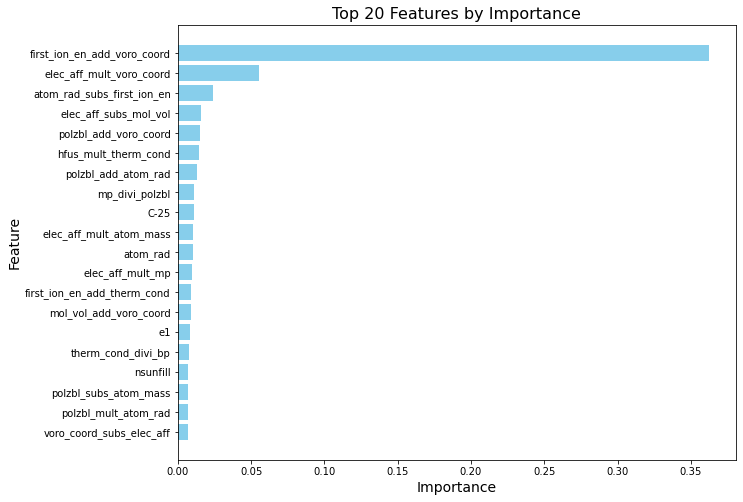

In [126]:
import matplotlib.pyplot as plt

# 创建水平条形图
plt.figure(figsize=(10, 8))
plt.barh(top_20_features['Feature'], top_20_features['Importance'], color='skyblue')
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Top 20 Features by Importance', fontsize=16)
plt.gca().invert_yaxis()  # 反转 y 轴，使得重要性高的特征显示在顶部
plt.show()
